<a href="https://colab.research.google.com/github/jvloo/wqd7006-machine-learning/blob/main/wqd7006_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
## Download datasets from Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download prashant268/chest-xray-covid19-pneumonia
! kaggle datasets download tawsifurrahman/covid19-radiography-database

! unzip chest-xray-covid19-pneumonia.zip
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [2]:
import os

## Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob

## Load SK Learn for GLCM
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Load Tensorflow for CNN
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

SIZE = 140
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 140

categories = {
  0: "PNEUMONIA",
  1: "COVID19",
  2: "NORMAL"
}

# Prepare Data

In [3]:
train_data = './Data/train/*'
test_data = './Data/test/*'

## Need more train data to balance the number of train and test data
train_data_2 = './COVID-19_Radiography_Dataset/COVID'

## Import the train data

In [4]:
train_images = []
train_labels = [] 
label = 0

## Import train data
for dir_path in glob.glob(train_data):
    categories[label] == os.path.normpath(dir_path).split(os.path.sep)[-1]
    print("Importing",categories[label],"train data")
    counter = 1
    
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        if(counter%200==0): print(counter,"images loaded")
            
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        
        train_images.append(img)
        train_labels.append(label)
        counter+=1
        
        if(counter%1500==0): break
    
    print(counter,"images loaded")
    label +=1
    
## Import additional train data
print("Importing additional",categories[2],"train data")    
additional_counter = 1

for img_path in glob.glob(os.path.join(train_data_2, "*.png")):
    if(additional_counter%200==0): print(additional_counter,"images loaded")
        
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, TARGET_SIZE)
    
    train_images.append(img)
    train_labels.append(2)
    additional_counter+=1
    
    if(additional_counter%1000==0): break
        
print(additional_counter,"images loaded")


x_train = np.array(train_images)
y_train = to_categorical(train_labels, 3)

Importing PNEUMONIA train data
200 images loaded
400 images loaded
461 images loaded
Importing COVID19 train data
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1267 images loaded
Importing NORMAL train data
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1400 images loaded
1500 images loaded
Importing additional NORMAL train data
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded


## Import the test data

In [5]:
test_images = []
test_labels = []
label = 0

## Import the test data
for dir_path in glob.glob(test_data):
    categories[label] == os.path.normpath(dir_path).split(os.path.sep)[-1]
    print("Importing",categories[label],"test data")
    counter = 1
    
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        if(counter%100==0): print(counter, "images loaded")
            
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        
        test_images.append(img)
        test_labels.append(label)
        counter+=1
    
    print(counter,"images loaded")
    label +=1

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, 3)

Importing PNEUMONIA test data
100 images loaded
117 images loaded
Importing COVID19 test data
100 images loaded
200 images loaded
300 images loaded
318 images loaded
Importing NORMAL test data
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
856 images loaded


## Split data into train and test dataset



In [6]:
train_test_split(train_images, train_labels)
train_images, val_images, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.15, random_state=69)

print("train:",train_images.shape[0],", test:",test_images.shape[0],", val:",val_images.shape[0])

train: 3590 , test: 1288 , val: 634


# Feature Extraction

## Traditional feature extraction: Gray-Level Co-Occurrence Matrix (GLCM)

In [7]:
def glcm_extract(images):
    image_dataset = pd.DataFrame()
    for image in images:   
        df = pd.DataFrame()
        dists = [[1],[3],[5],[3],[3]]
        angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]
        
        for n ,(dist, angle) in enumerate(zip(dists, angles)):
        
            GLCM = greycomatrix(image, dist, angle)       
            GLCM_Energy = greycoprops(GLCM, 'energy')[0]
            df['Energy'+str(n)] = GLCM_Energy
            GLCM_corr = greycoprops(GLCM, 'correlation')[0]
            df['Corr'+str(n)] = GLCM_corr       
            GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = GLCM_diss       
            GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
            df['Homogen'+str(n)] = GLCM_hom       
            GLCM_contr = greycoprops(GLCM, 'contrast')[0]
            df['Contrast'+str(n)] = GLCM_contr

        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [8]:
train_extr_features = glcm_extract(train_images)
test_extr_features = glcm_extract(test_images)
val_extr_features = glcm_extract(val_images)

In [9]:
## Convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')

## Normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [10]:
pd.set_option("display.max_columns", None)
train_extr_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.061726,0.953145,8.676567,0.228317,403.287153,0.040351,0.884224,18.061053,0.134664,952.254484,0.024494,0.793097,25.900635,0.094632,1627.447619,0.049086,0.909423,15.320783,0.147556,763.329500,0.068551,0.938615,11.455370,0.203906,541.482795
0,0.023737,0.958348,7.425231,0.242543,242.171480,0.017520,0.888723,15.186861,0.120888,643.041293,0.015551,0.832211,20.133704,0.082383,963.748307,0.018865,0.914176,12.795106,0.147613,496.016173,0.021386,0.944587,9.698488,0.202158,322.828728
0,0.017199,0.989581,5.951079,0.199332,76.080781,0.013262,0.953107,13.109906,0.105570,343.584463,0.011775,0.903684,19.295238,0.074383,707.777037,0.013870,0.956057,12.187251,0.106936,323.143772,0.014542,0.960575,11.351564,0.114696,293.912774
0,0.068314,0.942902,11.167677,0.161874,371.496146,0.045305,0.825511,22.288947,0.094928,1089.569447,0.024961,0.706351,30.263122,0.059072,1757.418466,0.056991,0.865449,19.836694,0.108532,856.287125,0.077843,0.897686,17.173253,0.149027,678.134567
0,0.024754,0.976294,5.475283,0.258934,118.962950,0.017552,0.917609,12.799739,0.121616,403.160219,0.014980,0.845833,18.674603,0.076680,734.951746,0.019044,0.942177,10.874869,0.136661,288.194234,0.022748,0.969093,7.722211,0.208758,157.960584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.031663,0.983223,3.554008,0.306917,40.847636,0.021833,0.927633,8.269030,0.146930,171.533055,0.018745,0.854281,12.310106,0.095160,337.661534,0.023241,0.945154,7.372033,0.163335,130.027778,0.025292,0.956377,6.285506,0.222973,105.990302
0,0.035623,0.972173,6.260637,0.276952,156.241316,0.030481,0.939217,11.431491,0.170911,340.369552,0.028574,0.907801,14.824815,0.139158,514.353386,0.027452,0.934554,11.528513,0.154837,361.769639,0.025885,0.924120,11.997862,0.144327,420.730292
0,0.042363,0.963819,9.602569,0.154783,227.998253,0.026544,0.856401,20.387591,0.088836,860.567987,0.019989,0.725500,28.429471,0.064427,1580.876561,0.032715,0.895527,17.716446,0.098062,639.802457,0.049561,0.931974,14.068665,0.136247,439.374922
0,0.028905,0.965813,8.752210,0.206346,290.408428,0.021070,0.891405,17.471741,0.111235,897.003128,0.018855,0.809838,23.755556,0.077635,1524.280423,0.022050,0.921771,14.896555,0.125413,654.815480,0.026638,0.947270,12.305787,0.166744,454.313191


## High-level feature extraction: Convolutional Neural Network (CNN)

### Convolutional Neural Network to extract the high-level features

In [11]:
def build_cnn():
    model = keras.Sequential([
        keras.Input(shape=(140,140,1), name='Original_Images'),
        keras.layers.Conv2D(input_shape=(140,140,1), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv1'),
        keras.layers.Conv2D(input_shape=(130,130,32), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv2'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(58,58,32), filters=64, kernel_size=9, 
                            strides=1, activation='relu', name='Conv3'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(23,23,64), filters=128, kernel_size=8, 
                            strides=1, activation='relu', name='Conv4'),
        keras.layers.Conv2D(input_shape=(16,16,128), filters=256, kernel_size=9, 
                            strides=1, activation='relu', name='Conv5'),
        keras.layers.Conv2D(input_shape=(8,8,256), filters=256, kernel_size=8, 
                            strides=1, activation='relu', name='Conv6'),    

        keras.layers.Flatten(),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense')
    ])
    print(model.summary())
    return model

### Multi-layer Perceptron to learn the numerical feature data extracted from the GLCM

In [12]:
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=25, name='Extracted_Traditional_Features'),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense2')
    ])
    print(model.summary())
    return model

### Intertwining the two feature extractors

In [13]:
mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense1 (Dense)              (None, 8)                 208       
                                                                 
 Dense2 (Dense)              (None, 4)                 36        
                                                                 
Total params: 244
Trainable params: 244
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 130, 130, 32)      3904      
                                                                 
 Conv2 (Conv2D)              (None, 120, 120, 32)      123936    
                                                                 
 max_pooling2d (MaxPooling2D  (

# Optimization of Model

## Optimize the model using ADAM

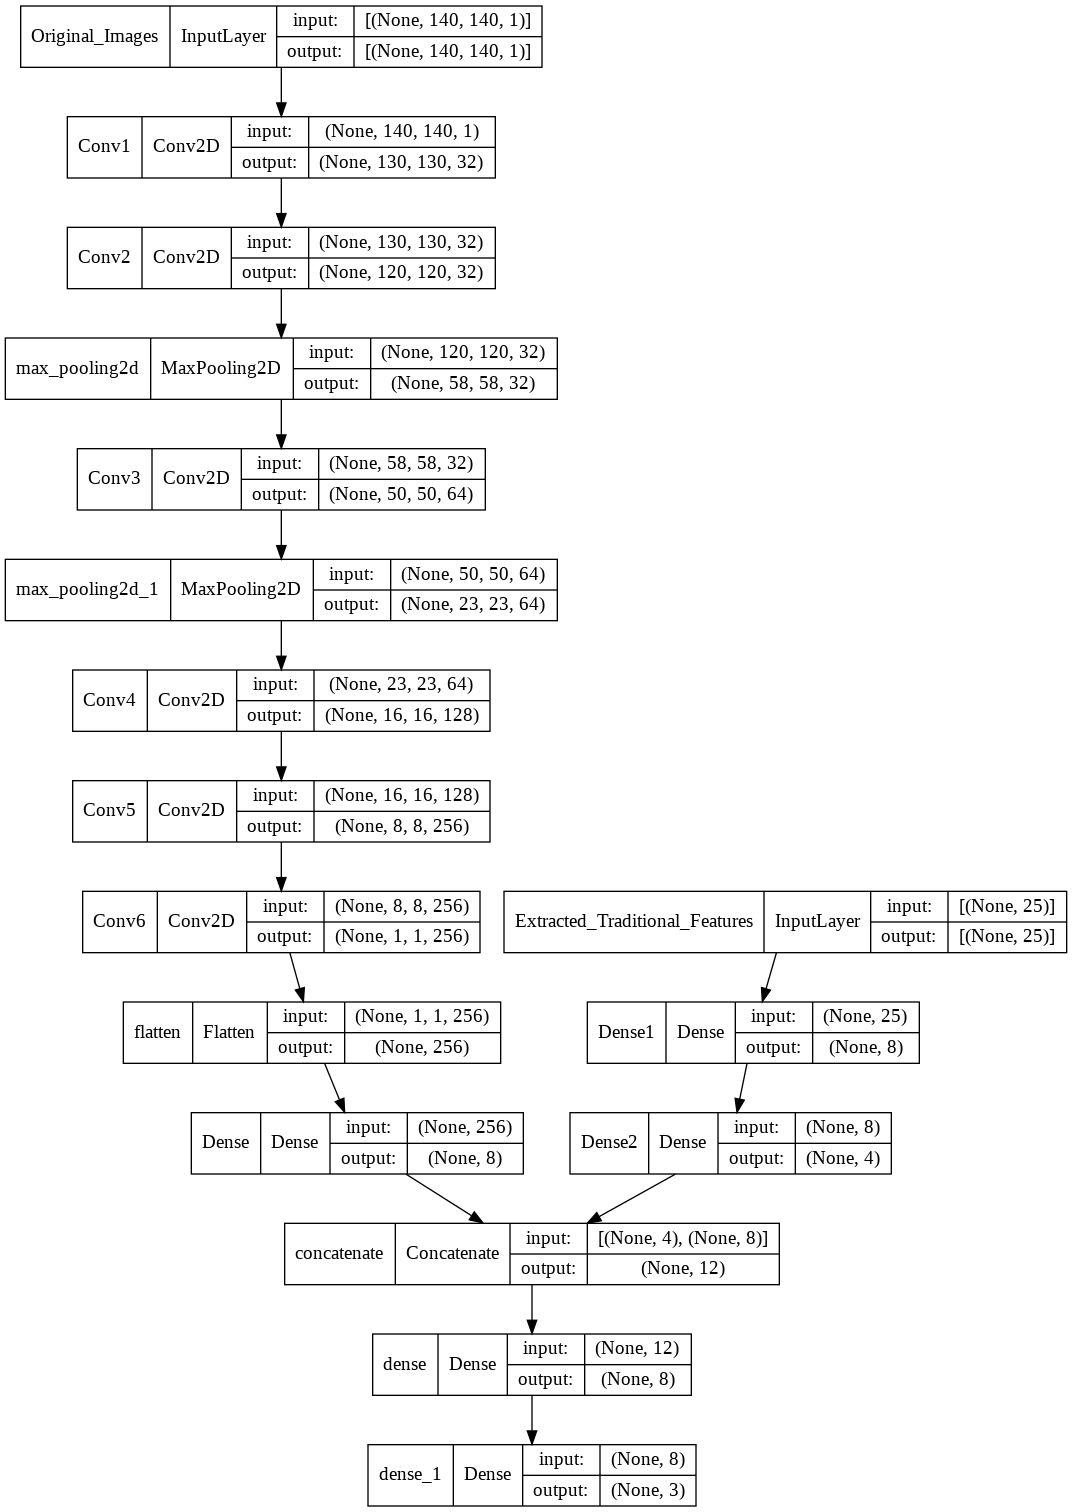

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Reduce Learning Rate on Plateau
To reduce the learning rate gradually if there is no significant improvement on the performance of the network.

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    )
]

# Training the Model

In [16]:
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_extr_features, tf.expand_dims(train_images_norm, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labels)

dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TRAIN= train_images_norm.shape[0]//BATCH_SIZE

history = model.fit(dataset, 
                    validation_data=([val_extr_features, tf.expand_dims(val_images_norm, axis=-1)], val_labels),
                    epochs = EPOCH_NUM, steps_per_epoch=STEP_SIZE_TRAIN, callbacks=cb)

model.save_weights('./kentang_net')

Epoch 1/140


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - ETA: 0s - loss: 441.8171 - categorical_accuracy: 0.4556

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 15s 80ms/step - loss: 441.8171 - categorical_accuracy: 0.4556 - val_loss: 3.0308 - val_categorical_accuracy: 0.6262 - lr: 0.0050
Epoch 2/140
56/56 [==============================] - 4s 65ms/step - loss: 1.6367 - categorical_accuracy: 0.5675 - val_loss: 1.1652 - val_categorical_accuracy: 0.6530 - lr: 0.0050
Epoch 3/140
56/56 [==============================] - 4s 64ms/step - loss: 0.9431 - categorical_accuracy: 0.6313 - val_loss: 0.8765 - val_categorical_accuracy: 0.6640 - lr: 0.0050
Epoch 4/140
56/56 [==============================] - 4s 64ms/step - loss: 0.8351 - categorical_accuracy: 0.6358 - val_loss: 0.8228 - val_categorical_accuracy: 0.6183 - lr: 0.0050
Epoch 5/140
56/56 [==============================] - 4s 64ms/step - loss: 0.7905 - categorical_accuracy: 0.6446 - val_loss: 0.7885 - val_categorical_accuracy: 0.6230 - lr: 0.0050
Epoch 6/140
56/56 [==============================] - 4s 64ms/step - loss: 0.7881 - categorical_accuracy: 0.6492 - 

# Testing the Model

In [17]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_extr_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labelz = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labelz)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

20/20 [==============================] - 0s 19ms/step - loss: 0.5691 - categorical_accuracy: 0.7852
Test loss: 0.5691298842430115 / Test accuracy: 0.78515625


# Evaluate the Model

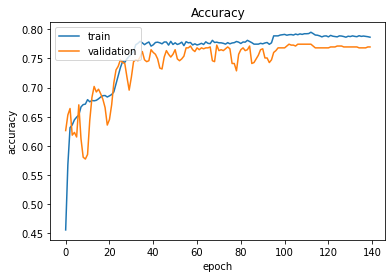

In [18]:
import matplotlib.pyplot as plt
history.history.keys()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()